# Lab 7 - RNN

This is a tutorial training various RNNs on simple datasets and doing some analysis.
In acest laborator vom parcurge notiuni introductive privind retelele recurente si folosirea lor pentru a prezice valori viitoare ale unei serii (i.e. setup predictiv - de regresie).

Structura:
  1. Implementarea unei celule RNN simple
  2. Implementarea unui model folosind o celula LSTM
  3. Intelegerea conceptului de **teacher forcing** si **warm start** (in cadrul predictiei)

## Importuri

In [29]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import LSTM


from matplotlib import pyplot as plt

sns.set_style('ticks')


# Task 1.    Vanilla RNN

Implementati o celula RNN de baza folosind straturi liniari din PyTorch.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Unde
   
   * $x_t$ inputul la momentul $t$ de dimensiunea (batch_size, input_features)
   * $h_t$ hidden state at time $t$ de dimensiunea (batch_size, hidden_size)
   * $W$ proiectie input-to-hidden (antrenabil) 
   * $V$ proiectie hidden-to-hidden (antrenabil)
   * $b$ bias (antrenabil)
   * $f$ functia non-lineara aleasa (de regula tanh)

In [30]:
#@title Vanilla RNN
class VanillaRNNCell(nn.Module):

    def __init__(self, hidden_size, activation=nn.Tanh, bias=True):
        """
        Constructor pentru o celula simpla RNNCell unde tranzitiile hidden-to-hidden
        sunt definite printr-un strat liniar, iar activarea implicita este `tanh`
        :param hidden_size: dimensiunea starii ascunse
        :param activation: functie de activare folosita pentru urmatoarei stari ascunse
        """
        super(VanillaRNNCell, self).__init__()

        self._hidden_size = hidden_size
        self._activation = activation()
        self._bias = bias

        # Create the hidden-to-hidden layer
        self._linear_hh = nn.Linear(hidden_size, hidden_size, bias=bias)


    def forward(self, inputs, hidden=None):
        out = inputs

        ## TODO 1.1: your code here - adaugati pasul recurent la inputuri
        ## `inputs` este deja rezultatul proiectiei liniare Wx_t
        ## out = ...
        if hidden is not None:
            out = self._activation(hidden + out)
        else:
            out = self._activation(out)
        ## TODO end code

        return out, out


class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False):
        """
        Creates a vanilla RNN where input-to-hidden is a nn.Linear layer
        and hidden-to-output is a nn.Linear layer

        :param input_size: the size of the input to the RNN
        :param hidden_size: size of the hidden state of the RNN
        :param output_size: size of the output
        """
        super(VanillaRNN, self).__init__()

        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias

        self.in_to_hidden = nn.Linear(self._input_size, self._hidden_size, bias=self._bias)
        self.rnn_cell = VanillaRNNCell(self._hidden_size, bias=self._bias)
        self.hidden_to_out = nn.Linear(self._hidden_size, self._output_size, bias=self._bias)

    def step(self, input, hidden=None):
        input_ = self.in_to_hidden(input)
        _, hidden_ = self.rnn_cell(input_, hidden=hidden)
        output_ = self.hidden_to_out(hidden_)

        return output_, hidden_

    def forward(self, inputs, hidden=None, force=True, warm_start=10):
        batch_size = inputs.size(0)
        steps = inputs.size(1)
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        outputs = torch.autograd.Variable(torch.zeros(batch_size, steps, self._output_size)).to(device)

        output_ = None
        hidden_ = hidden
        input_ = torch.zeros(batch_size, self._input_size)

        ## TODO 1.2 - your code here: propagati secventa de antrenare prin retea
        ## Nota:
        ##    inputs - tensor de forma (batch_size, seq_len, 1)
        ##    self.step primeste intrare de forma input: (batch_size, 1), hidden: (batch_size, hidden_size)
        ##    self.step intoarche iesire de forma output: (batch_size, 1), hidden: (batch_size, hidden_size)
        ## Daca flag-ul de `force` este True sau daca suntem la primul pas, self.step primeste ca input un element din secventa de intrare
        ## Daca flag-ul este False, self.step primeste ca input predictia anterioara a retelei
        ## Daca sunt in primii `warm_start` pasi, self.step primeste ca input un element din secventa de intrare
        for i in range(steps):
            ## input_ = ...
            input_ = inputs[:, i, :]
            if not force:
                if i < warm_start:
                    input_ = inputs[:, i, :]
                else:
                    input_ = output_

            output_, hidden_ = self.step(input_, hidden_)
            outputs[:, i, :] = output_
        ## end code

        return outputs, hidden_


# Task 2.    RNN simplu folosind un modul LSTM

In [31]:
class LSTMRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False, batch_first = True, num_layers = 1):
        super(LSTMRNN, self).__init__()
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias

        self.rnn = LSTM(input_size = input_size,
                        proj_size = output_size,
                        hidden_size = hidden_size,
                        bias=bias,
                        num_layers = num_layers,
                        batch_first = batch_first)


    def forward(self, inputs, hidden=None, force=True, warm_start=10):
        batch_size = inputs.size(0)
        steps = inputs.size(1)

        outputs = torch.autograd.Variable(torch.zeros(batch_size, steps, self._output_size)).to(device)

        output_ = torch.zeros(batch_size, 1, self._output_size)
        hidden_ = None
        input_ = torch.zeros(batch_size, 1, self._input_size)

        for i in range(steps):
            ## TODO 1.2 - your code here: propagati secventa de antrenare prin retea
            ## Nota:
            ##    inputs - tensor de forma (batch_size, seq_len, 1)
            ##    self.step primeste intrare de forma input: (batch_size, 1, 1), hidden: (batch_size, hidden_size)
            ##    self.step intoarche iesire de forma output: (batch_size, 1, 1), hidden: (1, batch_size, hidden_size)
            ## Daca flag-ul de `force` este True sau daca suntem la primul pas, self.step primeste ca input un element din secventa de intrare
            ## Daca flag-ul este False, self.step primeste ca input predictia anterioara a retelei
            ## Daca sunt in primii `warm_start` pasi, self.step primeste ca input un element din secventa de intrare
            ## input_ = ....
            input_ = inputs[:, [i], :]
            if not force:
                if i < warm_start:
                    input_ = inputs[:, [i], :]
                else:
                    input_ = output_
            ## end code
            output_, hidden_ = self.rnn(input_, hidden_)
            outputs[:, [i], :] = output_

        return outputs, hidden_

# Antrenarea retelei RNN pentru a prezice o curba sinusoidala

Antrenam reteaua pe o curba sinusoidala - predictia urmatoarei valori din sinusoida pe baza valorilor *prezise* anterior.

Predictie pentru   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

În special, dorim ca rețeaua să prezică următoarea valoare într-o buclă, condiționând predicția de unele valori inițiale (furnizate) și de toate predicțiile ulterioare.

Pentru a învăța modelul de predicție, vom folosi **teacher forcing**. Aceasta înseamnă că atunci când antrenam modelul, intrarea la momentul $t$ este secvența reală la momentul $t$, mai degrabă decât rezultatul produs de model la $t-1$. 

**Când dorim să generăm** date din model, **nu avem acces la succesiunea adevărată**, așa că nu folosim *teacher forcing*. 
Totuși, în cazul problemei noastre, vom folosi notiunea de **warm start (pornire la cald)**, deoarece avem nevoie de mai mulți pași de timp pentru a prezice următoarea valoare a undei sinusoidale (cel puțin 2, pentru valoarea inițială și pentru pas).

Codul de mai jos derulează modelul RNN pe care l-ați definit mai sus, face antrenamentul folosind backprop în timp (BPTT) și trasează datele reale ("ground truth"), datele generate în timpul antrenamentului ("training predictions") și eșantioanele de model "generate".

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f'Running code @ {device}')

Running code @ cuda


In [37]:
UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.001  #@param {type:"number"}
REPORTING_INTERVAL = 1000  #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1)
y_train = np.sin(x_train)


In [38]:
def create_batch(y_train, unroll_length, batch_size):
    y_batch = np.zeros((batch_size, unroll_length, 1))
    starts = np.zeros(batch_size, dtype=np.int64)

    for i in range(batch_size):
        start = np.random.choice(range(y_train.shape[0] - UNROLL_LENGTH))
        train_sequence = y_train[start : (start + UNROLL_LENGTH)]

        starts[i] = start
        y_batch[i, :, :] = train_sequence

    return y_batch, starts

[1000] avg_loss: 0.09928, report_loss: 0.04603, 


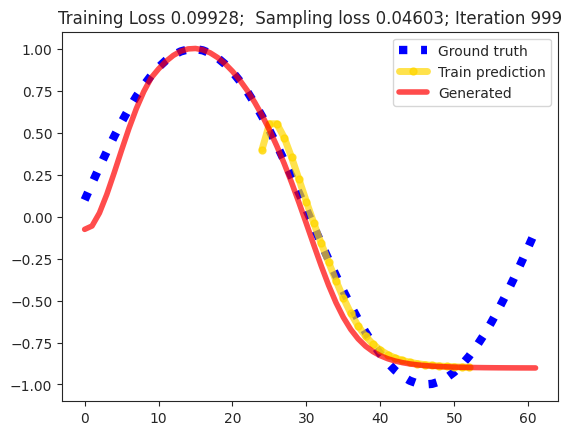

[2000] avg_loss: 0.01096, report_loss: 0.04354, 


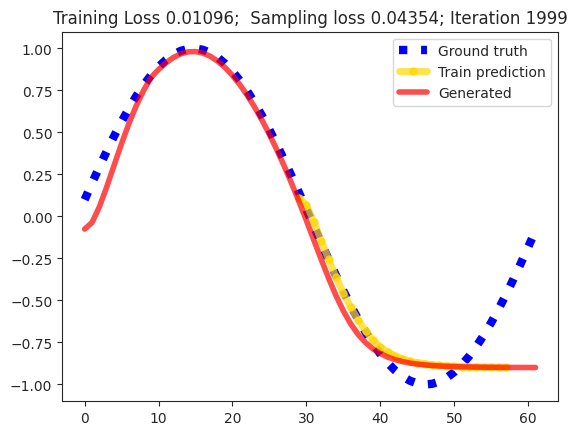

[3000] avg_loss: 0.00866, report_loss: 0.04154, 


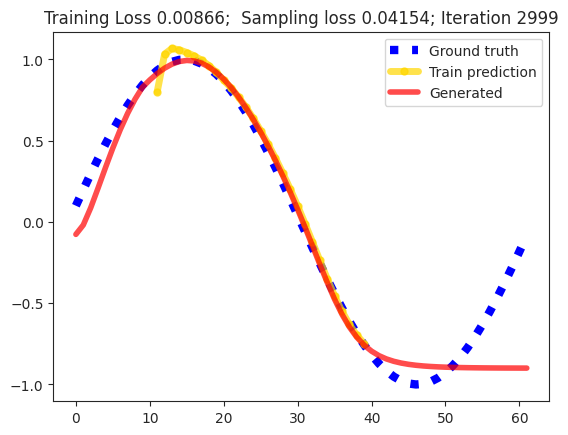

[4000] avg_loss: 0.00764, report_loss: 0.04129, 


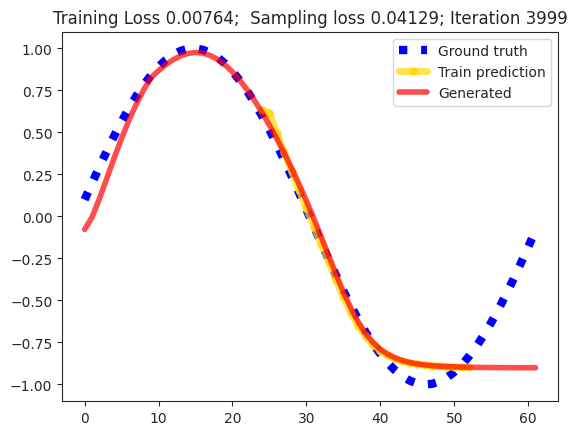

[5000] avg_loss: 0.00711, report_loss: 0.04109, 


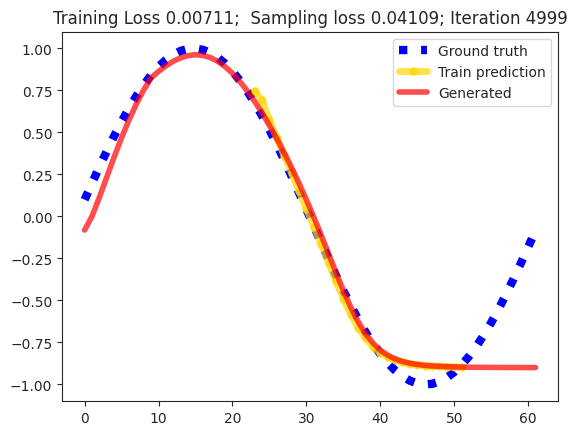

[6000] avg_loss: 0.00704, report_loss: 0.03932, 


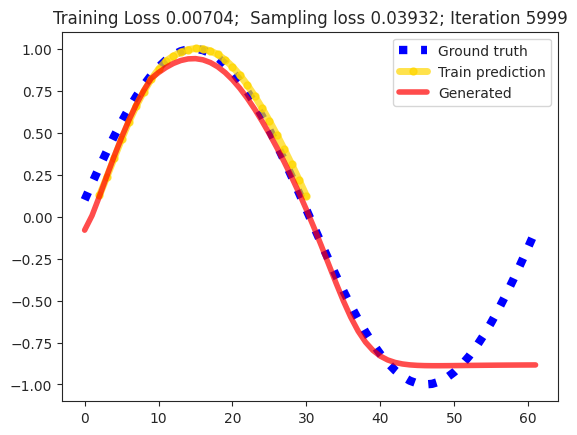

[7000] avg_loss: 0.00368, report_loss: 0.01411, 


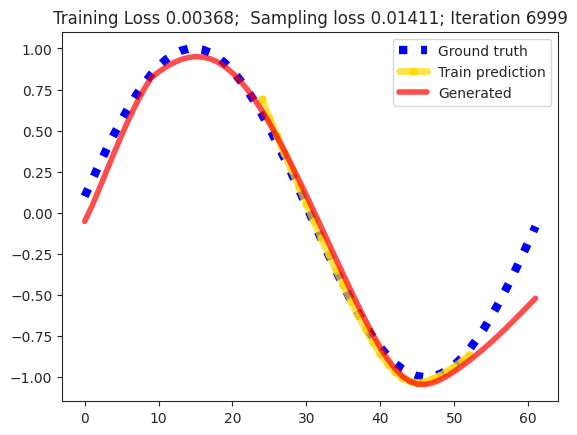

[8000] avg_loss: 0.00174, report_loss: 0.00529, 


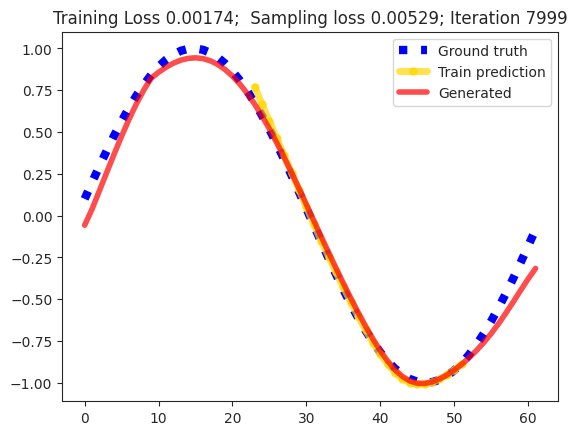

[9000] avg_loss: 0.00128, report_loss: 0.00411, 


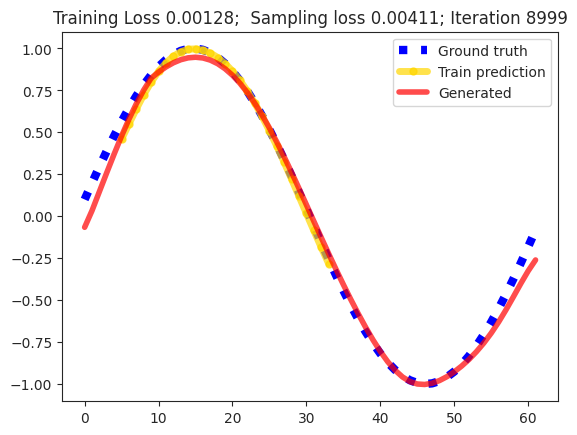

[10000] avg_loss: 0.00111, report_loss: 0.00384, 


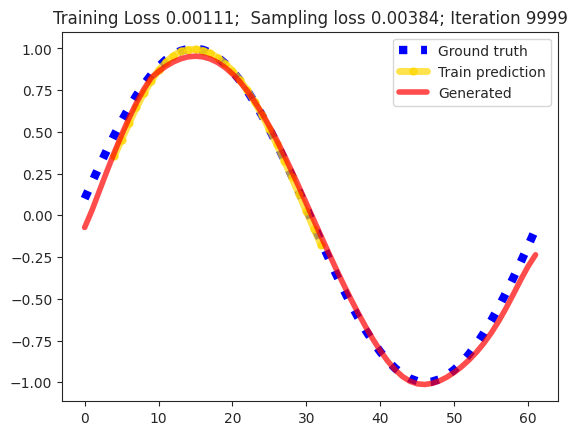

In [39]:
# net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=True)
net = LSTMRNN(hidden_size=HIDDEN_UNITS, bias=True, num_layers = 1)

net.train()
net = net.to(device)

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    train_batch, starts = create_batch(y_train, UNROLL_LENGTH, BATCH_SIZE)

    train_inputs = torch.from_numpy(train_batch[:,:-1,:]).float().view(BATCH_SIZE, UNROLL_LENGTH-1, 1).to(device)
    train_targets = torch.from_numpy(train_batch[:,1:, :]).float().view(BATCH_SIZE, UNROLL_LENGTH-1, 1).to(device)

    optimizer.zero_grad()

    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)

    loss = criterion(outputs, train_targets)
    loss.backward()

    running_loss += loss.item()

    optimizer.step()

    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        running_loss = 0

        report_sequence = torch.from_numpy(y_train[:-1]).float().view(1, len(y_train)-1, 1).to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().view(1, len(y_train)-1, 1).to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)

        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))

        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))

        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(starts[0], starts[0]+UNROLL_LENGTH-1), outputs[0, :, :].cpu().data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.cpu().data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

# TASK 3: Evaluarea influentei hiper-parametrilor

Testati pe baza codului de mai sus urmatoarele configuratii:
  * BATCH_SIZE: 1, 16, 32
  * UNROLL_LENGTH: 3, 10, 30, 62
  * TEACHER_FORCING: True, False
  * WARM_START: 2, 5, 10
  
Raspundeti la urmatoarele intrebari:
  1. Care este influenta TEACHER_FORCING-ului? In ce situatii ar trebui evitat / redus?
  2. Care este influenta UNROLL_LENGTH-ului (lungimea secventei de antrenare)? Ce se poate intampla daca UNROLL_LENGTH este foarte mic?
